# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
offer_ids = df_offers[['offer_id']]
merged = offer_ids.merge(df_transactions,'inner')
df_pivot = merged.pivot_table(index='customer_name',columns='offer_id').fillna(0)
df_pivot.head()

n                                              ...        \
offer_id        1    2    3    4    5    6    7    8    9    10 ...    23   
customer_name                                                   ...         
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0 ...   0.0   

                                                            
offer_id        24   25   26   27   28   29   30   31   32  
customer_name                                               
Adams          0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
Allen          0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
Anderson       1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
Baker          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 32 columns]

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 


### Checkup Exercise Set II

**Exercise:**

*   What values of $SS$ do you believe represent better clusterings? Why?

I believe that the specific value of $SS$ is not particularly important, so long as it is reduced as much as possible while still maintaining the integrity of analysis - that is, the clusters identified should correspond with something "real" and not be arbitrarily increased just to reduce $SS$.  Therefore, in this case we use the "elbow" method to see where the rate of change in $SS$ decreases as K increases.
*   Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)
*   Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.

In [5]:
#Create loop applying KMeans function on x_cols for each k and extracting sum of squares
from sklearn.cluster import KMeans
x_cols = df_pivot
k=2
SS = []
k_list = []
for num in range(2,10):
    for x in range(50):
        kmeans=KMeans(n_clusters=k)
        kmeans.fit(x_cols)
        SS.append((k,kmeans.inertia_))
    k_list.append(k)
    k+=1

*   Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.

Since there is a noticible change in the rate of $SS$ decrease from k3 to k4, we will use k3 for future clustering.

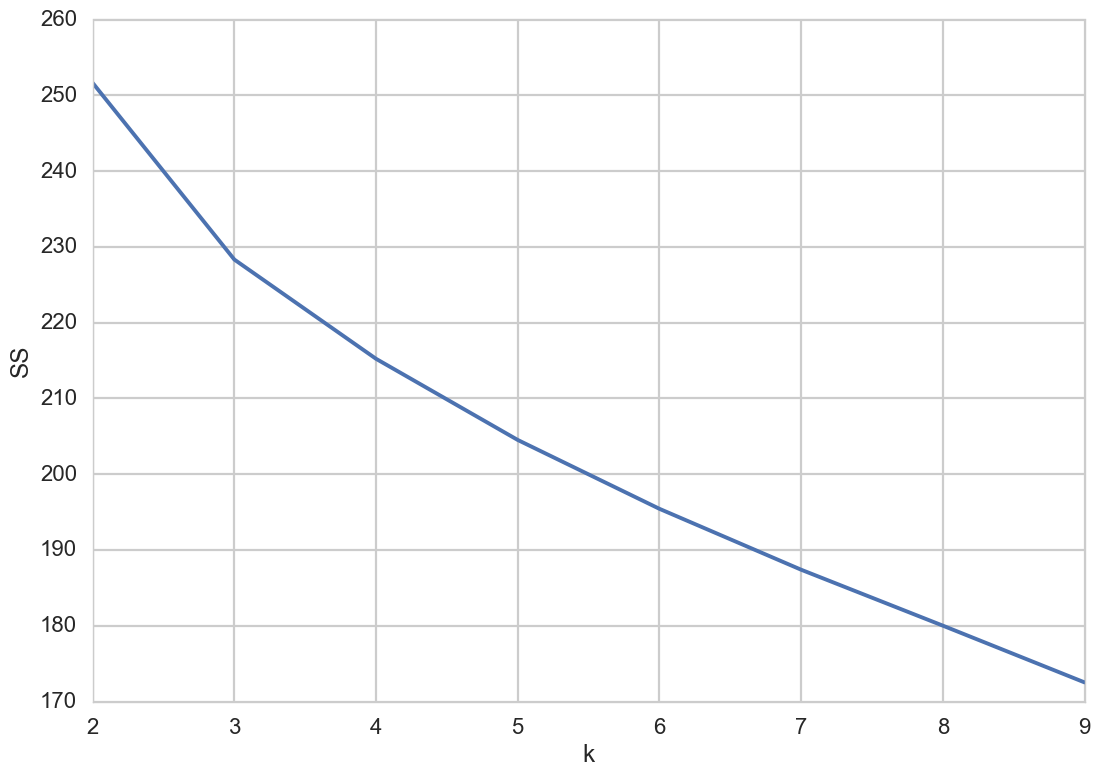

In [6]:
#Plot elbow chart using Sum of Squares for each k
SS_means = pd.DataFrame(SS)
SS_means.columns = ('K','SS')
SS_means = SS_means.pivot_table(values = 'SS', index = 'K')
fig, ax = plt.subplots()
ax.plot(SS_means)
ax.set_xlabel("k")
ax.set_ylabel("SS")

* Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
* What challenges did you experience using the Elbow method to pick $K$?

I found that, while the rate of SS change was different after k3, there was not a huge difference.  I would need to find some corroborating evidence from other methods before settling on k3.

In [7]:
#Loop iterates over the kmeans function, populating a dataframe with 
#the cluster predictions for each iteration.
df_clusters = pd.DataFrame(columns = ['Predicted_Cluster','Iteration'])
predicts = pd.DataFrame(columns = ['Predicted_Cluster','Iteration'])
kmeans=KMeans(n_clusters=3)
iteration = 1
for x in range(50):
    kmeans.fit(x_cols)
    predicts['Predicted_Cluster'] = (kmeans.predict(x_cols))
    predicts['Iteration'] = iteration
    df_clusters = df_clusters.append(predicts)
    iteration +=1
#Group by cluster predictions, divide by number of iterations
avg_clusters = pd.DataFrame(df_clusters.groupby('Predicted_Cluster').size()/iteration).round().rename(columns = {0:'Counts'})

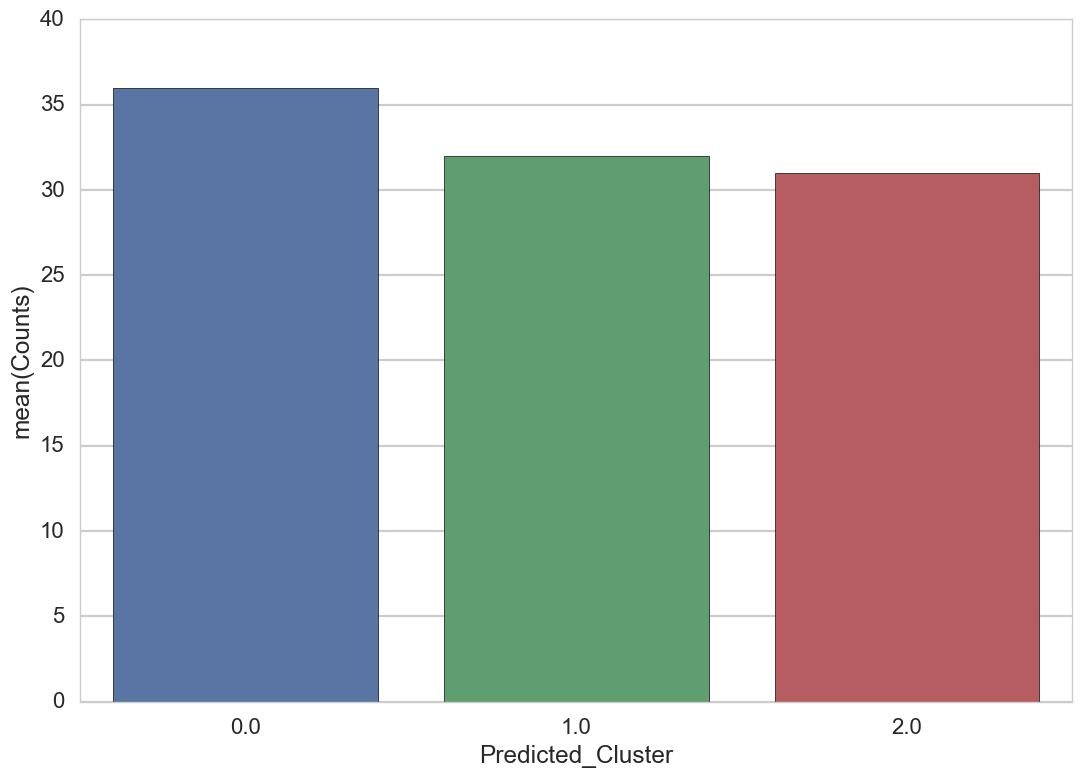

In [8]:
#Barplot of average cluster predictions
sns.barplot(x = avg_clusters.index,y = 'Counts',data = avg_clusters)

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

### Checkup Exercise Set III

**Exercise:** Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.

For n_clusters = 2 The average silhouette_score is : 0.0936557328349
For n_clusters = 3 The average silhouette_score is : 0.118899428636
For n_clusters = 4 The average silhouette_score is : 0.123470539196
For n_clusters = 5 The average silhouette_score is : 0.14092516242
For n_clusters = 6 The average silhouette_score is : 0.137179893911
For n_clusters = 7 The average silhouette_score is : 0.116109245662
For n_clusters = 8 The average silhouette_score is : 0.113395738326
For n_clusters = 9 The average silhouette_score is : 0.125059605278
For n_clusters = 10 The average silhouette_score is : 0.119283321348


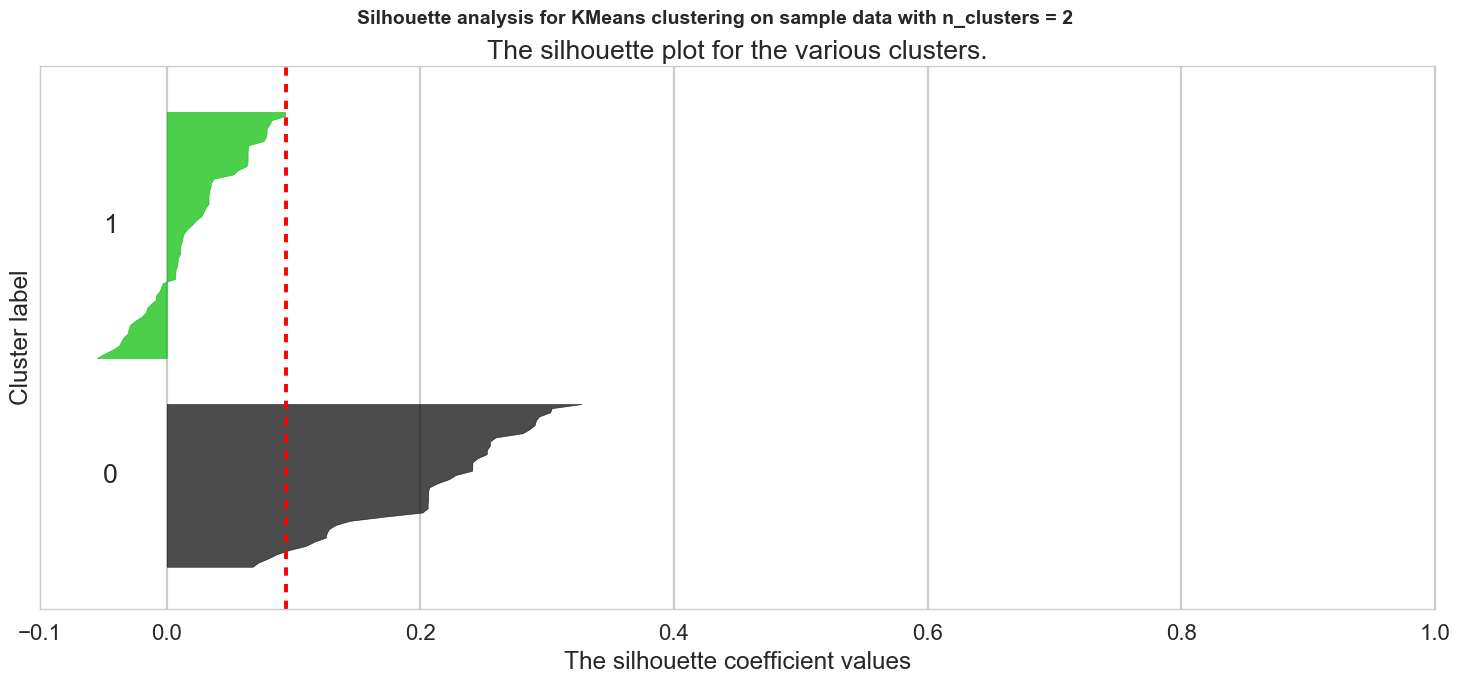

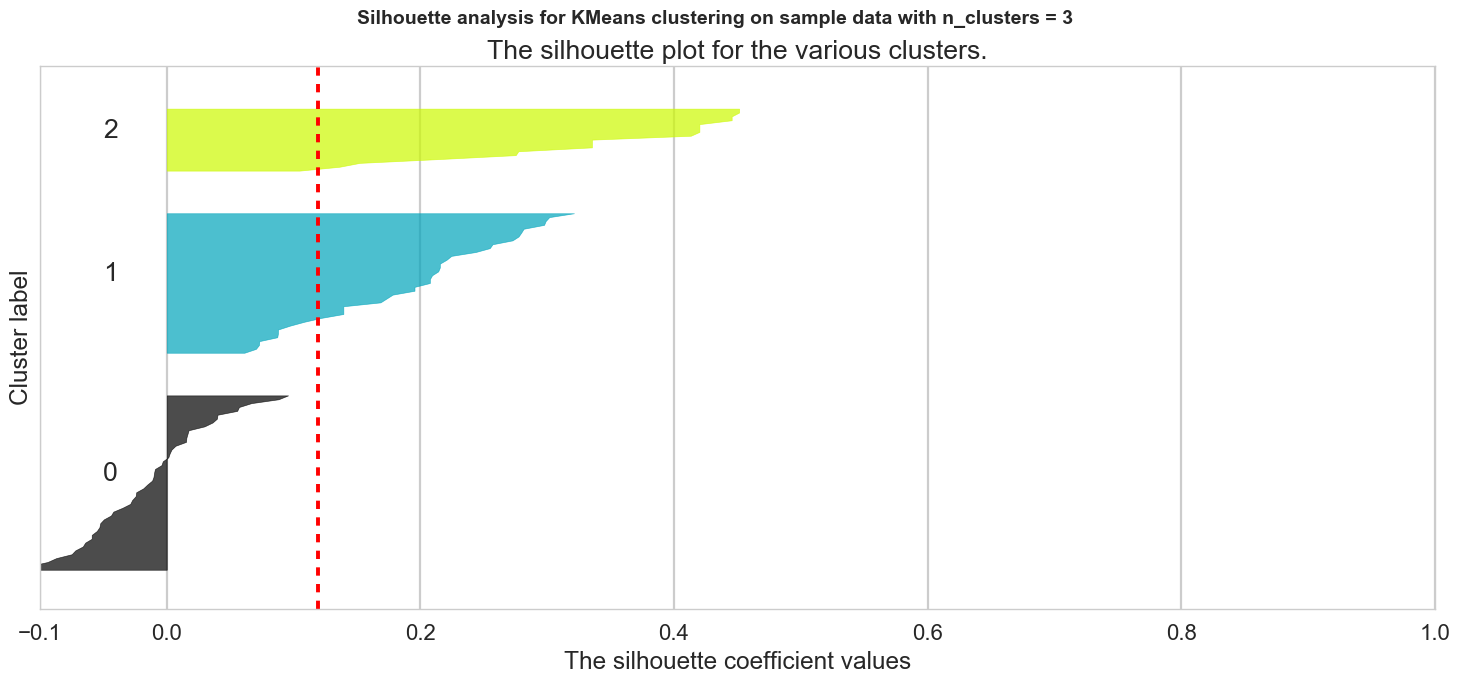

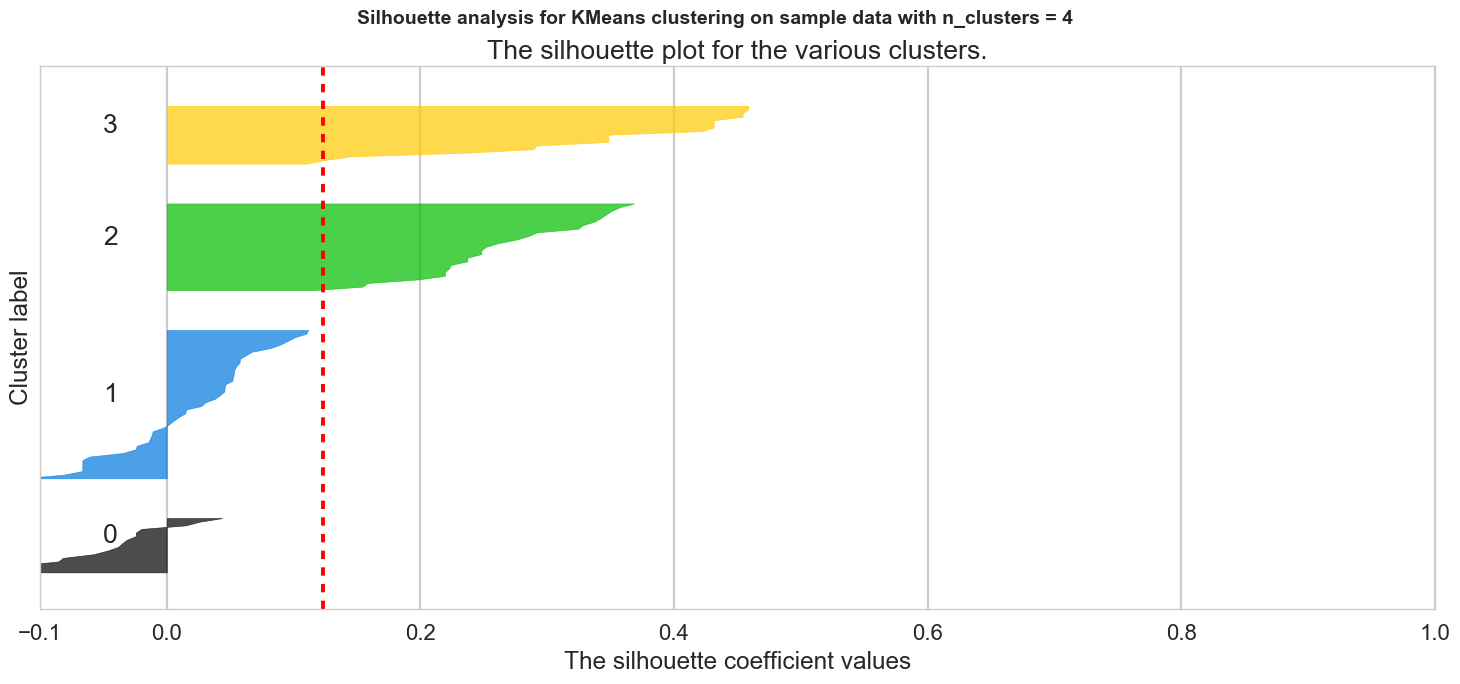

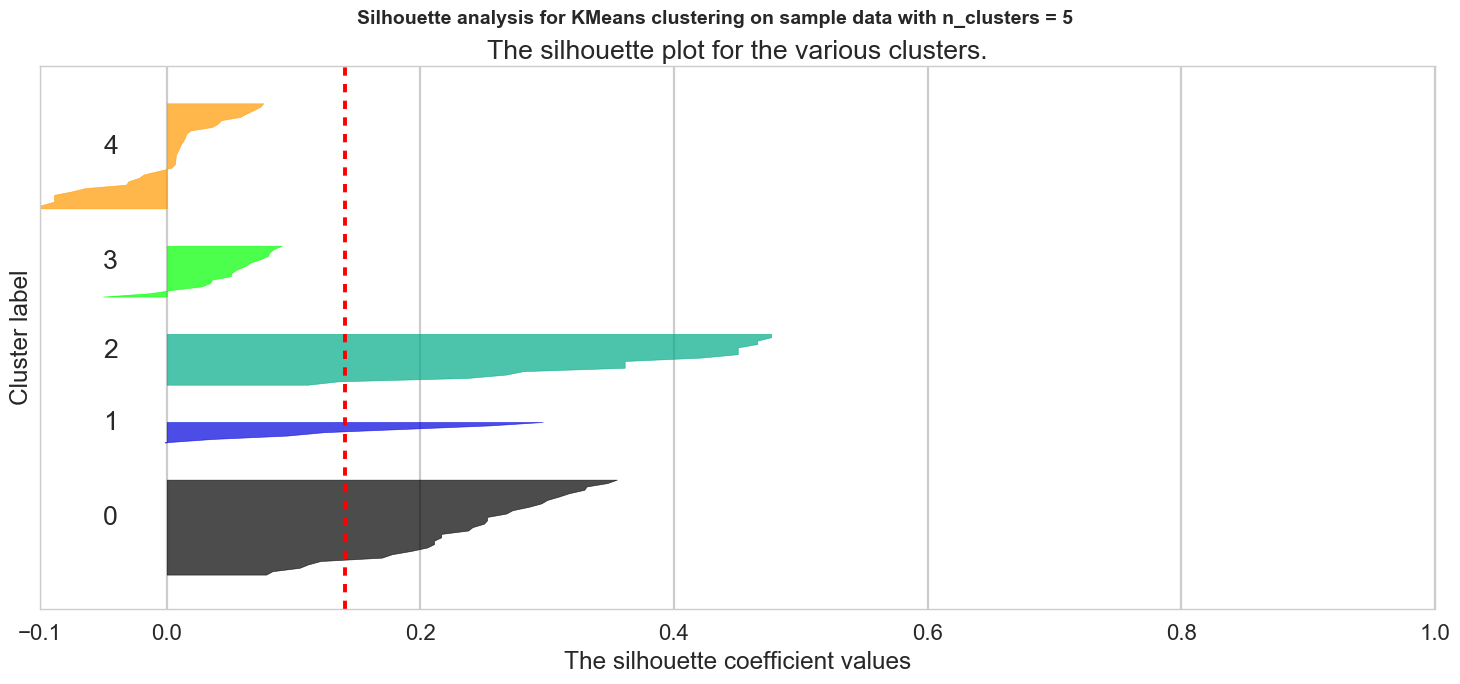

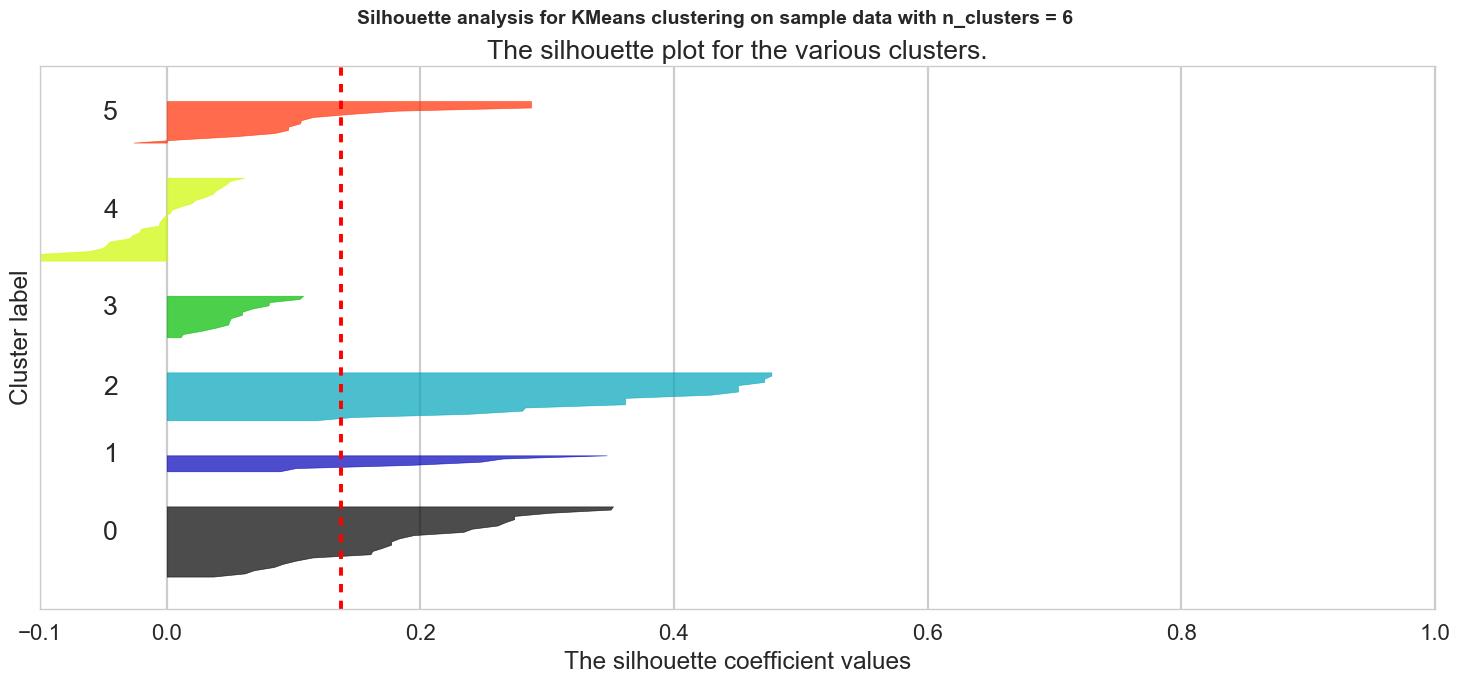

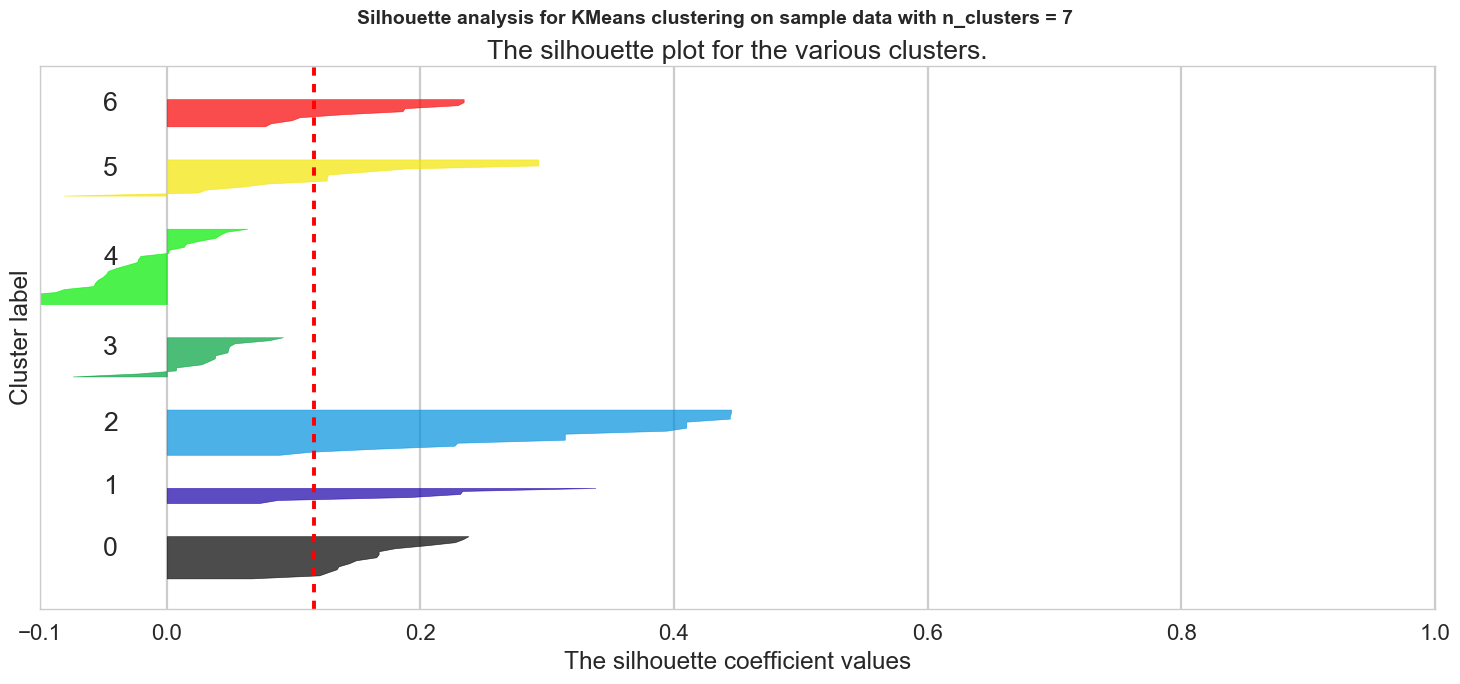

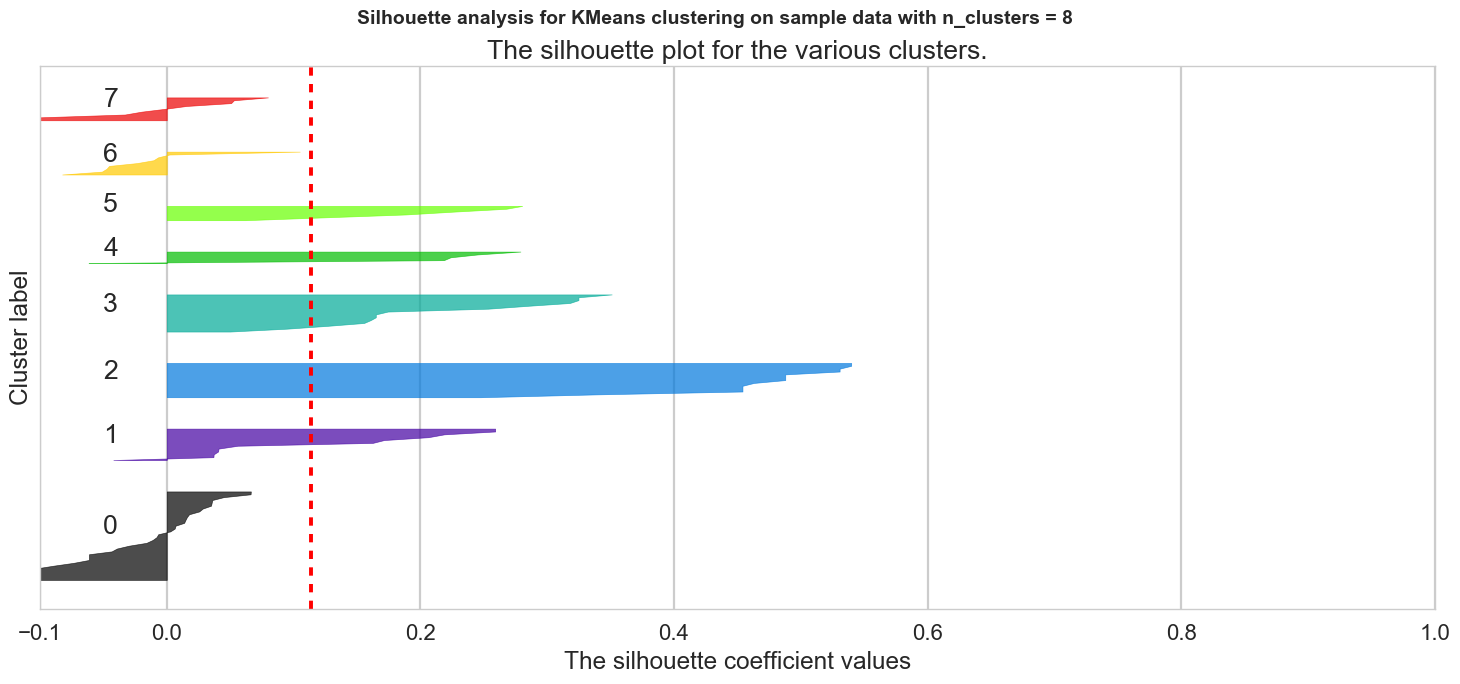

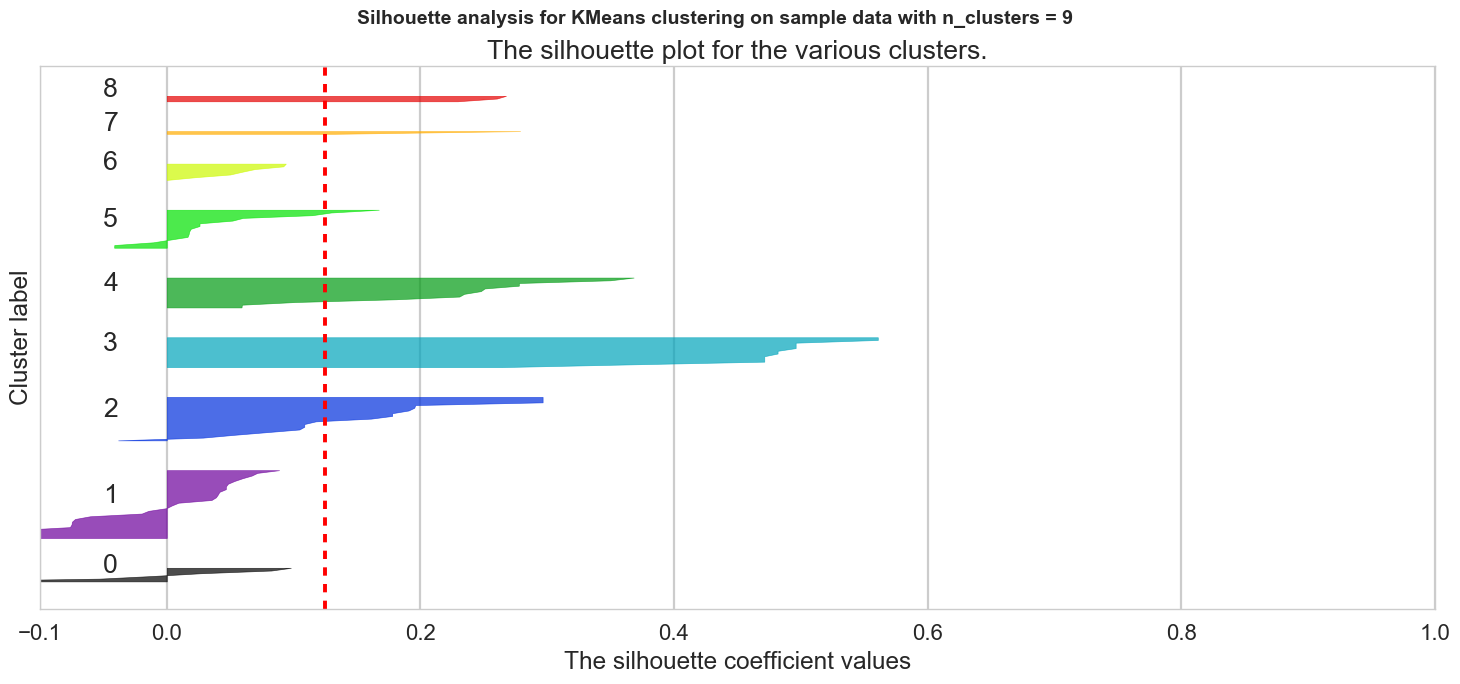

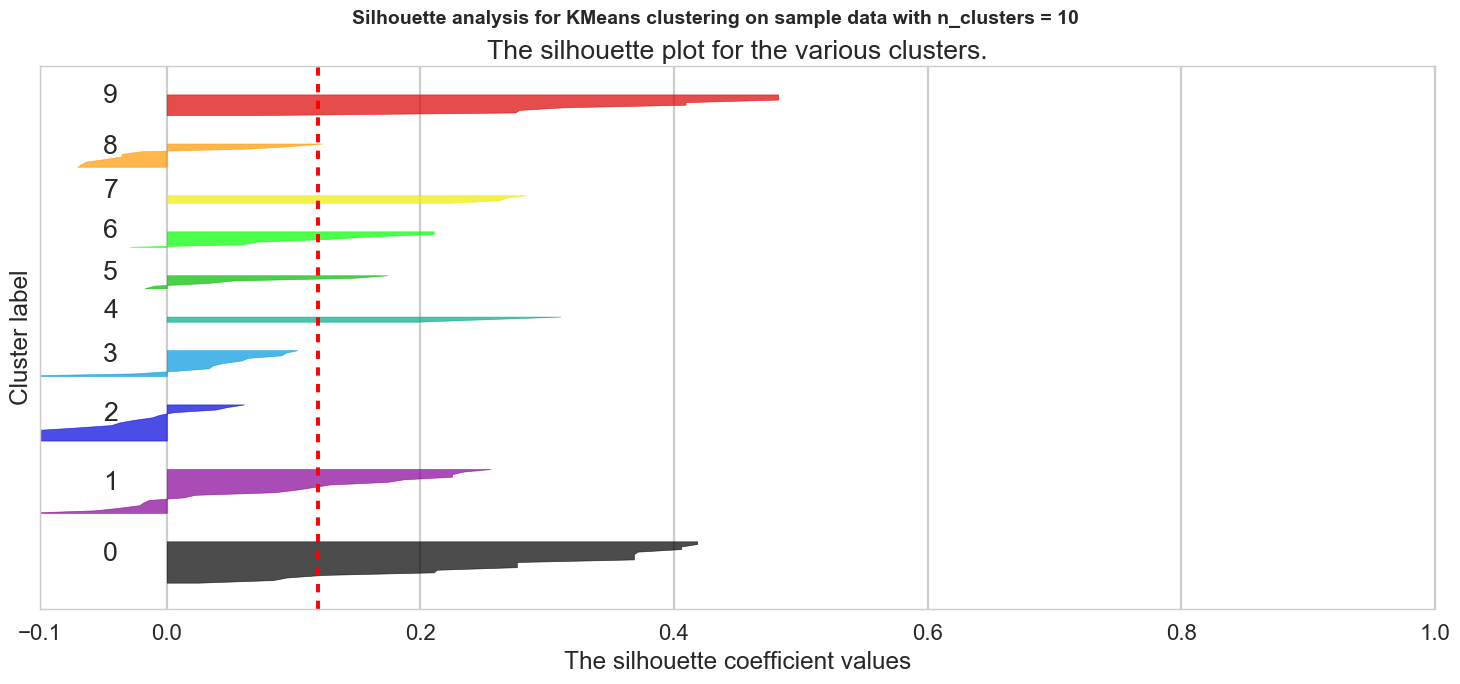

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
X = x_cols
matrix = x_cols.reset_index()
silhouette_list = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_list.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    matrix['x'] = pca.fit_transform(X)[:,0]
    matrix['y'] = pca.fit_transform(X)[:,1]
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

**Exercise:** Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

This plot suggests that we should use k=5, or possibly k=6, depending on how these values relate to possible real-world business factors.

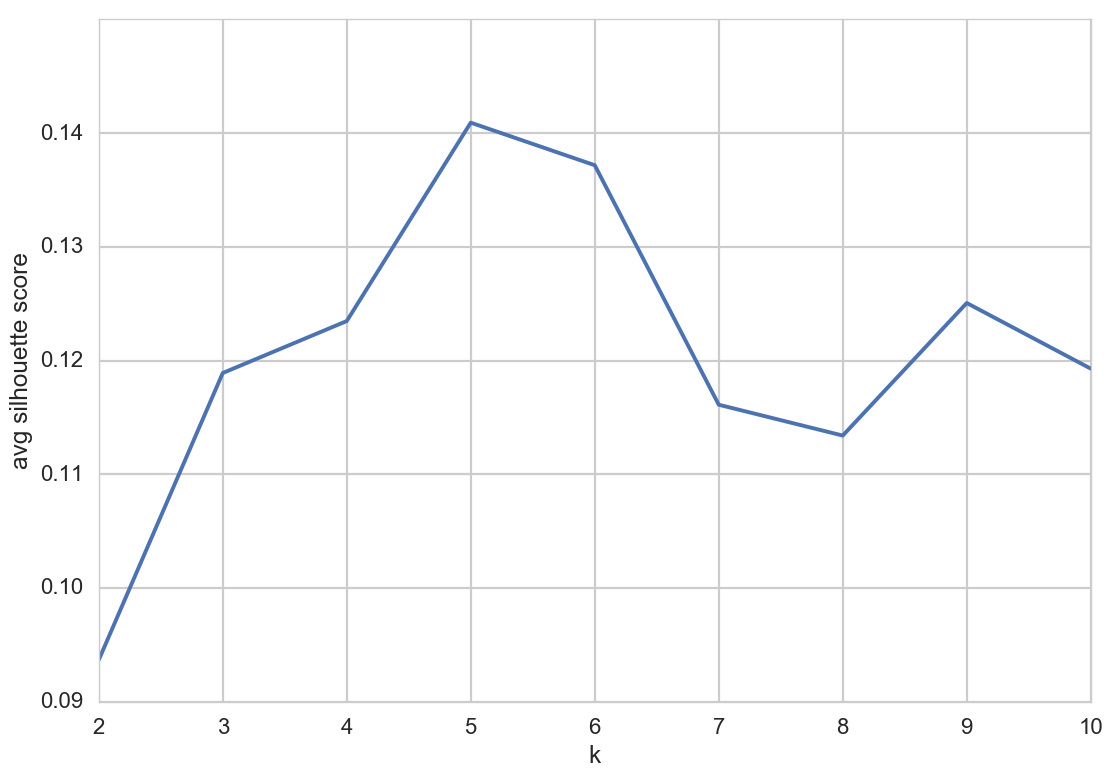

In [33]:
fig, (ax1) = plt.subplots(1)
ax1.plot(range_n_clusters,silhouette_list)
ax1.set_xlabel("k")
ax1.set_ylabel("avg silhouette score")

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

### Checkup Exercise Set IV

**Exercise:** Use PCA to plot your clusters:

*   Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
*   Create a data frame with the following fields:
    *   customer name
    *   cluster id the customer belongs to
    *   the two PCA components (label them `x` and `y`)
*   Plot a scatterplot of the `x` vs `y` columns
*   Color-code points differently based on cluster ID
*   How do the clusters look?
*   Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
    * K3 creates the most visually distinct and consistent clusters.  K5 also does well, although there tends to be some overlap in the clusters in the middle of the plot (where x<0 and y<0.5).  Given the strong performance on silhouette score along with the relatively consistent clustering, if I had to choose a single K-value, I would choose K5 as the most optimal K-value. However, it may be useful to analyze the relationship between clusters, the "real-world" data/business objectives, and both the K3 and K5 clusterings.

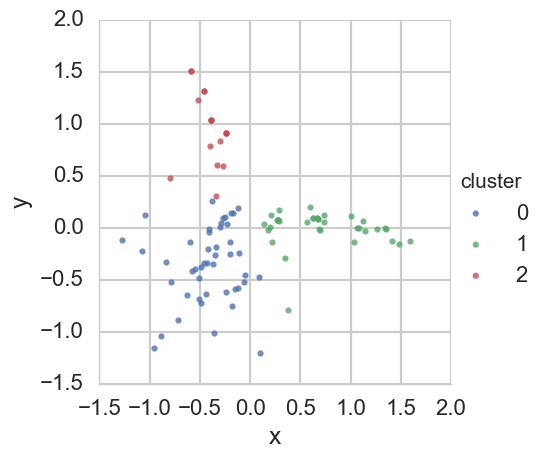

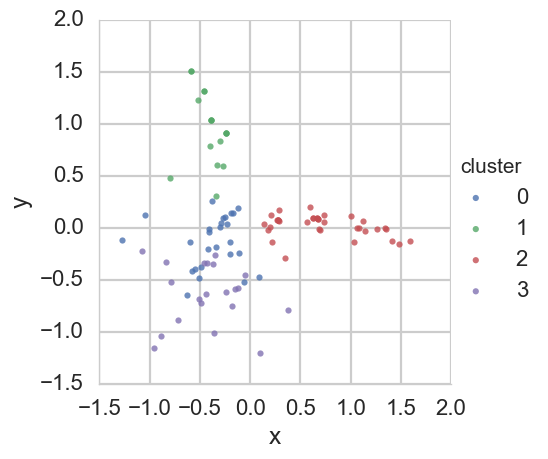

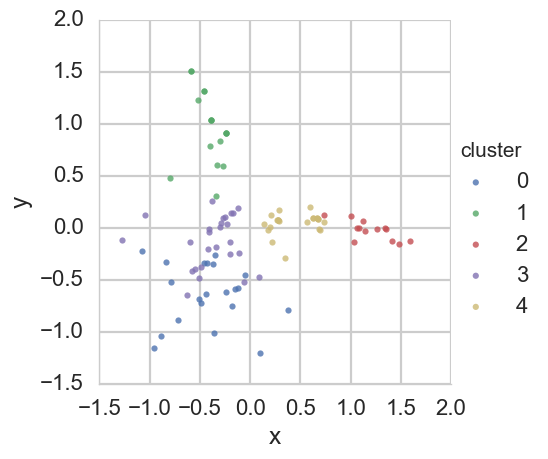

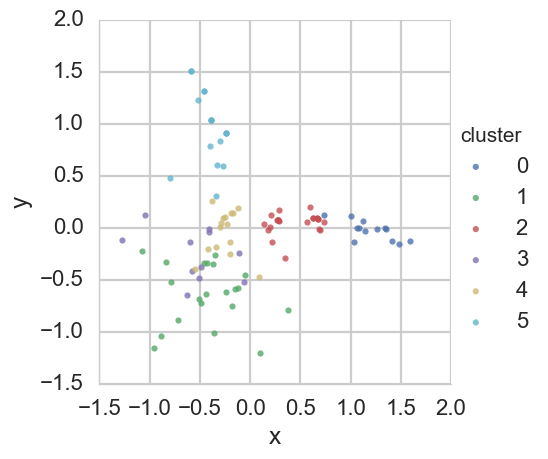

In [346]:
#Loop over and create color-coded scatter plot for each K from 3 to 6
from sklearn.decomposition import PCA
cluster_count = 3
matrix = x_cols.reset_index()
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(X)[:,0]
matrix['y'] = pca.fit_transform(X)[:,1]
for num in range (4):
    cluster = KMeans(n_clusters=cluster_count)
    pca = PCA(n_components=2)
    matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])
    PCA_values = matrix[['customer_name','cluster', 'x', 'y']]
    sns.lmplot(x="x", y="y", hue='cluster',data=PCA_values,fit_reg=False)
    cluster_count+=1

**Exercise:** Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [83]:
cluster_count = 3
matrix = x_cols.reset_index()
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(X)[:,0]
matrix['y'] = pca.fit_transform(X)[:,1]
cluster = KMeans(n_clusters=cluster_count)
matrix['cluster3'] = cluster.fit_predict(matrix[matrix.columns[2:]])
cluster_count = 5
cluster = KMeans(n_clusters=cluster_count)
matrix['cluster5'] = cluster.fit_predict(matrix[matrix.columns[2:]])
PCA_values = matrix[['customer_name','cluster3','cluster5', 'x', 'y']]
PCA_values.head()

,customer_name,cluster3,cluster5,x,y
offer_id,,,,,
0,Adams,1,4,1.007580,0.108215
1,Allen,0,2,-0.287539,0.044715
2,Anderson,2,3,-0.392032,1.038391
3,Bailey,1,4,0.699477,-0.022542
4,Baker,0,2,0.088183,-0.471695


C:\Users\David\Anaconda3\lib\site-packages\pandas\core\base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)
C:\Users\David\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


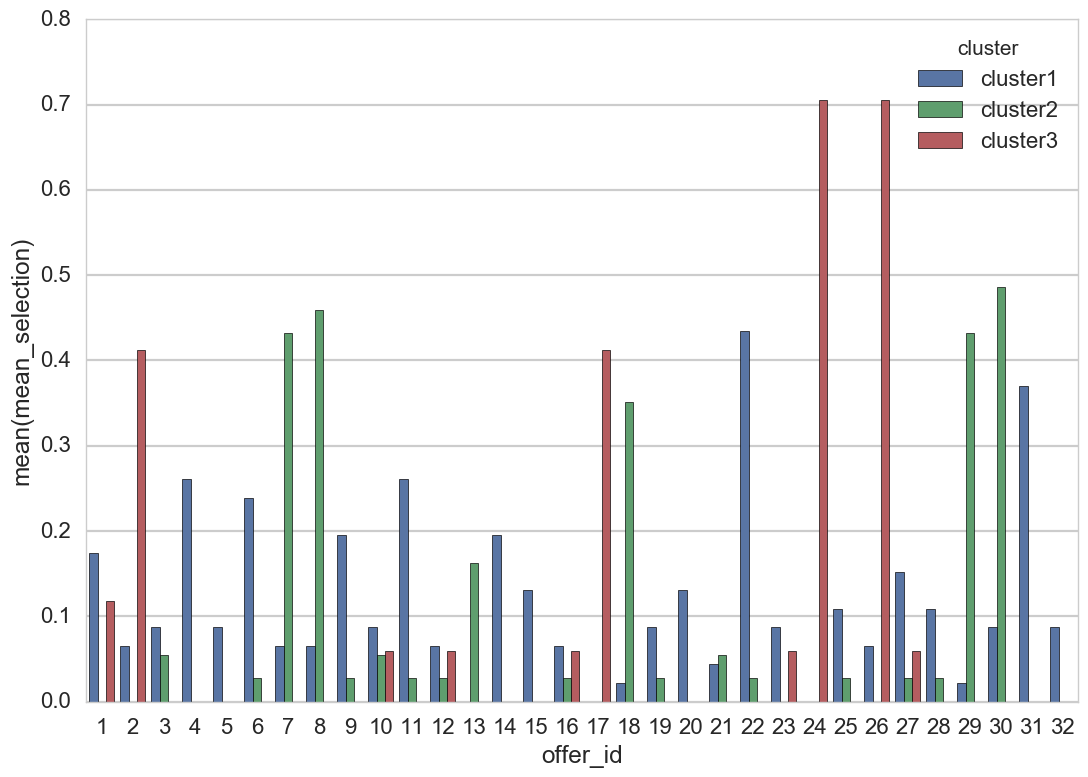

In [205]:
#Wrangling to get dataframe into correct shape for barplot
df_joined = PCA_values.join(df_pivot, on='customer_name')
k3_groups = df_joined.groupby('cluster3').mean()
k3_groups = k3_groups.drop('cluster5',1).drop('x',1).drop('y',1).reset_index()
k3_groups = k3_groups.pivot_table(columns='cluster3').reset_index().drop('level_0',1)
k3_groups.columns = ['offer_id','cluster1','cluster2','cluster3']
k3_groups = k3_groups.stack().reset_index()
k3_groups.columns = ['offer_id','cluster','mean_selection']
k3_groups['offer_id'] = k3_groups['offer_id'] + 1
k3_groups = k3_groups.drop(k3_groups[k3_groups.cluster == 'offer_id'].index)
#Barplot to compare incidence of offer ids for each cluster
sns.barplot(x="offer_id", y="mean_selection", hue='cluster',data=k3_groups)

In [227]:
#Dataframe showing the highest value for each offer id.  
#By counting the "Highest" column, we see that cluster 1 has the most "highest" values.
df_joined = PCA_values.join(df_pivot, on='customer_name')
k3_groups = df_joined.groupby('cluster3').mean()
k3_groups = k3_groups.drop('cluster5',1).drop('x',1).drop('y',1).reset_index()
k3_groups = k3_groups.pivot_table(columns='cluster3').reset_index().drop('level_0',1)
k3_groups.columns = ['offer_id','cluster1','cluster2','cluster3']
k3_groups['Highest'] = k3_groups[['cluster1','cluster2','cluster3']].idxmax(axis=1)
k3_groups.groupby('Highest').size()

C:\Users\David\Anaconda3\lib\site-packages\pandas\core\base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)
C:\Users\David\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


Highest
cluster1    21
cluster2     7
cluster3     4
dtype: int64

# Analysis for K=3
By plotting the average rate of selection of each offer for each cluster, we can see which wine offers are most frequently selected in each cluster.  Interestingly, clusters 2 and 3 have the most "standout" offers (selection rate > 0.4), while cluster 1 only has one such offer.  Also, cluster 3 has by far the most distinct offers, with offer 24 and 26 both above a 0.7 selection rate.  However, cluster 1 contains the greatest number of "highest" offers - where the selection rate was highest among the three clusters.  This suggests that clusters 2 and 3 correspond with distinct factors related to each offer, while cluster 1 may be more of an "all others" cluster, at least in this analysis with only 3 clusters.  

To examine what factors are related to each cluster, we will examine the row contents for each offer that had a selection rate >0.2:

- Cluster 1: 4,6,11,22,31
- Cluster 2: 7,8,18,29,30
- Cluster 3: 2,17,24,26

Upon review of the offers table (below), we can identify some trends based on the "standout" offers in each cluster.  From these, we generate the following insights:

 - Cluster 1 is related to French Champagnes with a min_qty of 72, as well as Chilean wines.  This could suggest that cluster 1 actually contains more than one "true" cluster in this analysis; we could see more distinct clusters emerge when K=5.  
 - Cluster 2 is related to min_qty of 6.
 - Cluster 3 is related to Pinot Noir, particularly in the autumn months (since offers 24 and 26 were both above a 0.7 selection rate and were in September and October, respectively)

In [222]:
#Offers for cluster 1
df_offers.loc[df_offers['offer_id'].isin([4,6,11,22,31])]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
3,4,February,Champagne,72,48,France,True
5,6,March,Prosecco,144,86,Chile,False
10,11,May,Champagne,72,85,France,False
13,14,June,Merlot,72,64,Chile,False
21,22,August,Champagne,72,63,France,False
30,31,December,Champagne,72,89,France,False


In [187]:
#Offers for cluster 2
df_offers.loc[df_offers['offer_id'].isin([7,8,18,29,30])]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
17,18,July,Espumante,6,50,Oregon,False
28,29,November,Pinot Grigio,6,87,France,False
29,30,December,Malbec,6,54,France,False


In [188]:
#Offers for cluster 3
df_offers.loc[df_offers['offer_id'].isin([2,17,24,26])]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False


C:\Users\David\Anaconda3\lib\site-packages\pandas\core\base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)
C:\Users\David\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


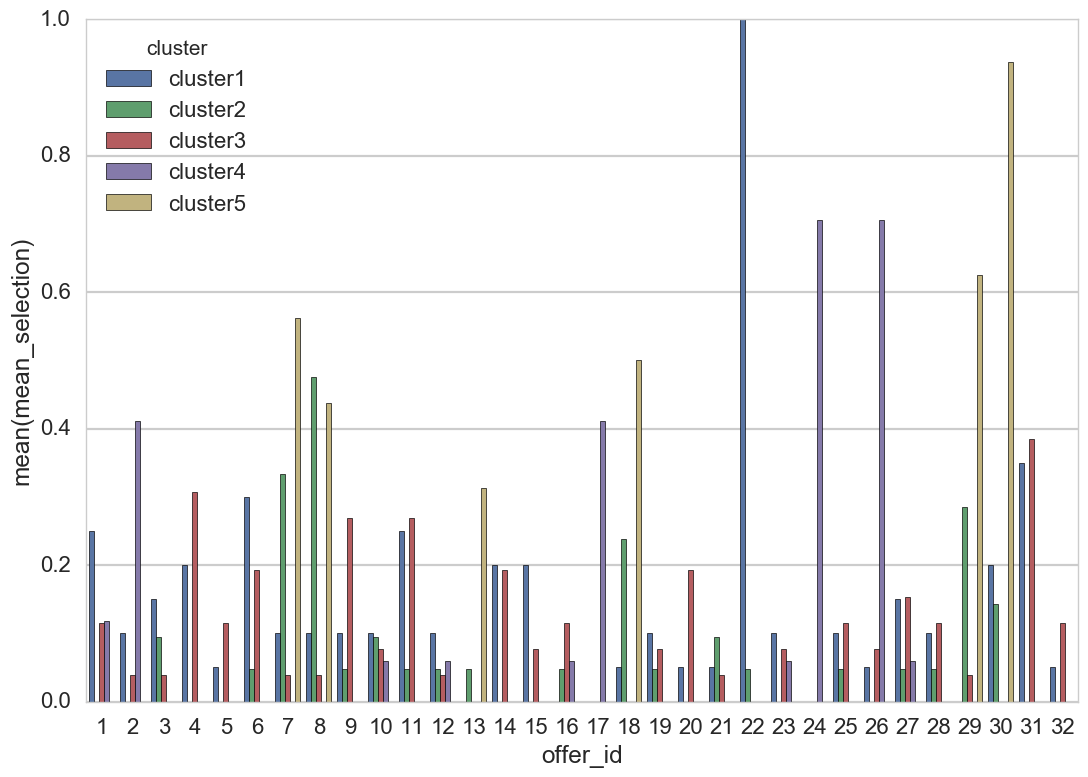

In [230]:
#Wrangling to get dataframe into correct shape for barplot
df_joined = PCA_values.join(df_pivot, on='customer_name')
k5_groups = df_joined.groupby('cluster5').mean()
k5_groups = k5_groups.drop('cluster3',1).drop('x',1).drop('y',1).reset_index()
k5_groups = k5_groups.pivot_table(columns='cluster5').reset_index().drop('level_0',1)
k5_groups.columns = ['offer_id','cluster1','cluster2','cluster3','cluster4','cluster5']
k5_groups = k5_groups.stack().reset_index()
k5_groups.columns = ['offer_id','cluster','mean_selection']
k5_groups['offer_id'] = k5_groups['offer_id'] + 1
k5_groups = k5_groups.drop(k5_groups[k5_groups.cluster == 'offer_id'].index)
#Barplot to compare incidence of offer ids for each cluster
sns.barplot(x="offer_id", y="mean_selection", hue='cluster',data=k5_groups)

In [232]:
#Dataframe showing the highest value for each offer id.  
#By counting the "Highest" column, we see that cluster 1 has the most "highest" values.
df_joined = PCA_values.join(df_pivot, on='customer_name')
k5_groups = df_joined.groupby('cluster5').mean()
k5_groups = k5_groups.drop('cluster3',1).drop('x',1).drop('y',1).reset_index()
k5_groups = k5_groups.pivot_table(columns='cluster5').reset_index().drop('level_0',1)
k5_groups.columns = ['offer_id','cluster1','cluster2','cluster3','cluster4','cluster5']
k5_groups['Highest'] = k5_groups[['cluster1','cluster2','cluster3','cluster4','cluster5']].idxmax(axis=1)
k5_groups.groupby('Highest').size()

C:\Users\David\Anaconda3\lib\site-packages\pandas\core\base.py:324: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return self.obj.drop(self.exclusions, axis=1)
C:\Users\David\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


Highest
cluster1    10
cluster2     2
cluster3    11
cluster4     4
cluster5     5
dtype: int64

# Analysis for K = 5
### Note: Clusters for K5 DO NOT correspond with the same cluster numbers in K3, i.e., cluster 1 in K3 is distinct from cluster 1 in K5.

As with K3, we observe that for several clusters there are distinctly high selection rates for some offers, while in other clusters there are fewer or less distinct offers.  In this case, clusters 1, 4, and 5 contain the most distinct values.  Surprisingly, cluster 1 contains a relatively high number of highest values while also containing the most distinct value (1.0 for offer 22).  

To examine what factors are related to each cluster, we will examine the row contents for each offer that had a selection rate >0.2:

- Cluster 1: 1,6,11,22,31
- Cluster 2: 7,8,18,29
- Cluster 3: 4,9,11,31
- Cluster 4: 2,17,24,26
- Cluster 5: 7,8,13,18,29,30

Upon review of the offers table (below), we can identify some trends based on the "standout" offers in each cluster.  From these, we generate the following insights:

 - Cluster 1 is related to French Champagne and Malbec with a min_qty of 72.  The relationship with offer 22, which matches this description, is particularly strong, with a 1.0 selection rate.   
 - Cluster 2 is related to min_qty of 6, and contains two instances of Espumante as well as 2 instances of a March campaign.  
 - Cluster 3 overlaps somewhat with cluster 1, with offers 11 and 31 in common, and also includes several French Champagnes, as well as a Chilean wine, which was also found in cluster 1 (although not the same offer).  This suggests that Clusters 1 and 3 are subsets of cluster 1 from the K3 analysis, and may in fact not be distinct in any meaningful way.  
 - Cluster 4 is related to pinot noirs and overlaps completely with cluster 3 from the K3 analysis.  These clusters appear to be the same no matter which K-value is used.
 - Cluster 5 is related to a min_qty of 6, and overlaps completely with cluster 2.  

# Overall Analysis
Based on my analysis of the 5 cluster model, seeing the significant overlap between clusters 1 and 3 as well as clusters 2 and 5, it seems that a 5 cluster model does not offer significant improvement over the 3 factor model in terms of real business insights, overall, it appears that there are two particularly meaningful clusters; one related to French Champagne and, to a lesser extent, Chilean wines, and one related to a min_qty of 6.  The third major cluster is difficult to segment in a meaningful way and may simply represent customers who do not have a consistent preference for a certain type or quanity of wine - any attempt to segment further may only improve the model insofar as it removes unnecessary values from the more consistent clusters.

**The primary business insight derived from this clustering is that there is a distinct population that buys mostly French Champagne, and a distinct population that buys mostly small amounts of wine at a time.**

In [234]:
#Offers for cluster 1
df_offers.loc[df_offers['offer_id'].isin([1,6,11,22,31])]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
5,6,March,Prosecco,144,86,Chile,False
10,11,May,Champagne,72,85,France,False
21,22,August,Champagne,72,63,France,False
30,31,December,Champagne,72,89,France,False


In [233]:
#Offers for cluster 2
df_offers.loc[df_offers['offer_id'].isin([7,8,18,29])]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
17,18,July,Espumante,6,50,Oregon,False
28,29,November,Pinot Grigio,6,87,France,False


In [235]:
#Offers for cluster 3
df_offers.loc[df_offers['offer_id'].isin([4,9,11,31])]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
3,4,February,Champagne,72,48,France,True
8,9,April,Chardonnay,144,57,Chile,False
10,11,May,Champagne,72,85,France,False
30,31,December,Champagne,72,89,France,False


In [236]:
#Offers for cluster 4
df_offers.loc[df_offers['offer_id'].isin([2,17,24,26])]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False


In [237]:
#Offers for cluster 5
df_offers.loc[df_offers['offer_id'].isin([7,8,13,18,29,30])]

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
12,13,May,Merlot,6,43,Chile,False
17,18,July,Espumante,6,50,Oregon,False
28,29,November,Pinot Grigio,6,87,France,False
29,30,December,Malbec,6,54,France,False


### Exercise Set V

As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?

**Exercise:** Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?

     * The elbow point for the plot of PCA explained variance is 4, so 5 is a possible optimal number of dimensions (since the origin is technically 1 dimension, not 0.

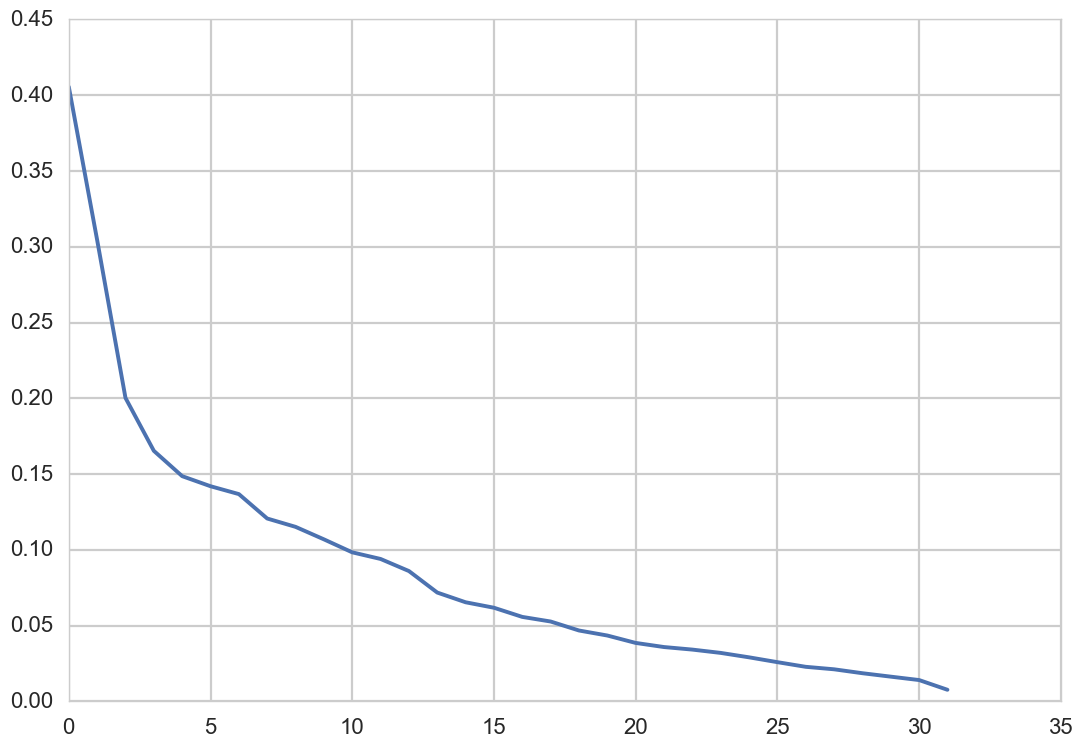

In [20]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
ev = pca.explained_variance_
fig, ax = plt.subplots(1)
ax.plot(ev)

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

### Exercise Set VI

**Exercise:** Try clustering using the following algorithms.

1.  Affinity propagation
2.  Spectral clustering
3.  Agglomerative clustering
4.  DBSCAN

How do their results compare? Which performs the best? Tell a story why you think it performs the best.
 - I found that Agllomerative clustering performed the best for this problem, although spectral clustering also did well - the only significant difference is that Agglomerative clustering allows for different numbers of clusters.  The output of this function most closely matched the more visually apparent clusters, and there is no overlap between clusters.  In contrast, most other algorithms, including KMeans, resulted in significant overlap between clusters.  The output from the Affinity Propagation algorithm was almost totally illegible.  

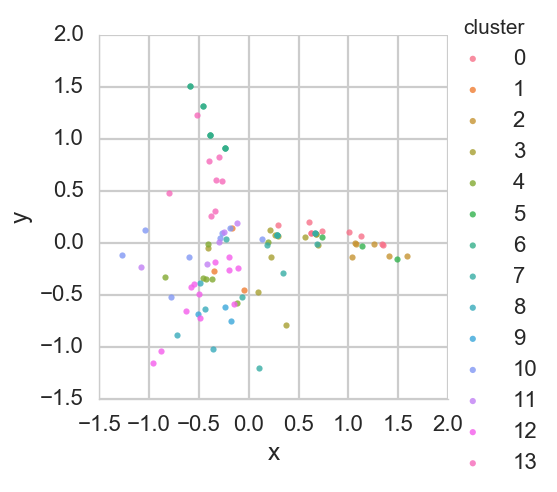

In [385]:
# Affinity propagation
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
X = x_cols
af = AffinityPropagation().fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
matrix = x_cols.reset_index()
pca = PCA(n_components=4)
matrix['x'] = pca.fit_transform(X)[:,0]
matrix['y'] = pca.fit_transform(X)[:,1]
matrix['cluster'] = labels
PCA_values = matrix[['customer_name','cluster', 'x', 'y']]
XY = PCA_values[['x','y']].as_matrix()

sns.lmplot(x="x", y="y", hue='cluster',data=PCA_values,fit_reg=False)

C:\Users\David\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


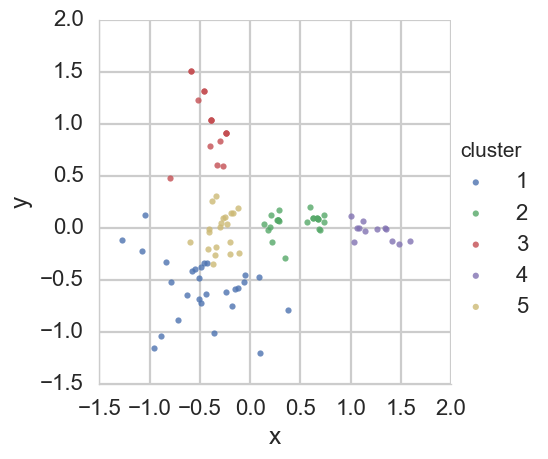

In [397]:
from sklearn.cluster import SpectralClustering
cl = SpectralClustering(affinity='precomputed')
Predicts = AC.fit_predict(XY)
PCA_values['cluster']=Predicts+1
sns.lmplot(x="x", y="y", hue='cluster',data=PCA_values,fit_reg=False)

C:\Users\David\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\David\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


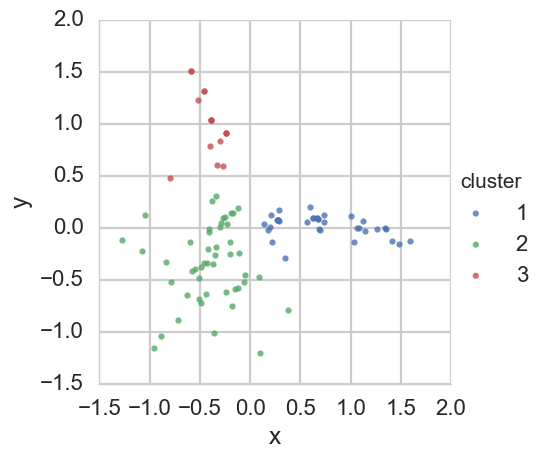

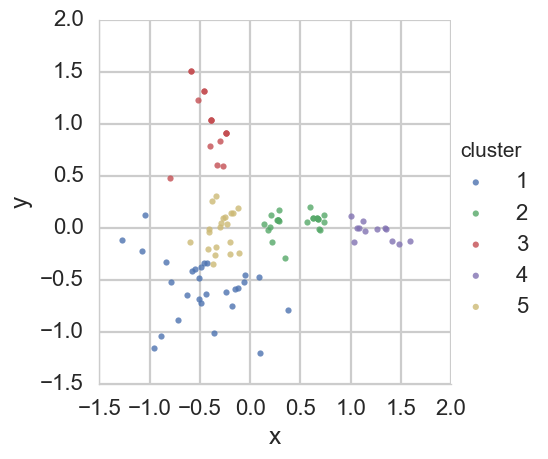

In [393]:
from sklearn.cluster import AgglomerativeClustering
#3 Cluster algorithm
AC = AgglomerativeClustering(n_clusters = 3)
Predicts = AC.fit_predict(XY)
PCA_values['cluster']=Predicts+1
sns.lmplot(x="x", y="y", hue='cluster',data=PCA_values,fit_reg=False)
#5 Clusters
AC = AgglomerativeClustering(n_clusters = 5)
Predicts = AC.fit_predict(XY)
PCA_values['cluster']=Predicts+1
sns.lmplot(x="x", y="y", hue='cluster',data=PCA_values,fit_reg=False)

C:\Users\David\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


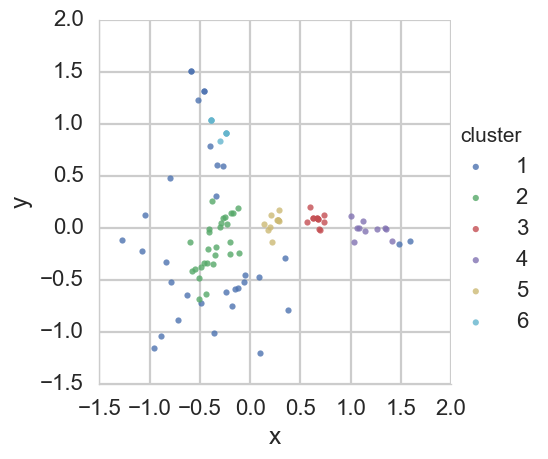

In [396]:
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps = 0.2, min_samples=7)
Predicts = DB.fit_predict(XY)
PCA_values['cluster']=Predicts+2
sns.lmplot(x="x", y="y", hue='cluster',data=PCA_values,fit_reg=False)